# RL methods for continuous states

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import optax

from jax import nn
from typing import NamedTuple
from functools import partial

In [2]:
key = jax.random.PRNGKey(20251204)

## Example model

We're going to start with a McCall model with job separation. Wages are going to be drawn from a continuous distribution $F(w)$ -- We will choose to draw log wages from a normal distribution.

If an individual accepts a wage $w$ then they begin working at that wage in the next period and have a probability $\alpha$ of losing their job which takes effect in the next period. While the worker is unemployed, they receive unemployment compensation $c$.

The individual consumes all of their income each period and has a utility function $u$ that satisfies the "usual conditions"

**The state**

Each period's state is going to be the current wage offer.

Note that if we were to solve this with dynamic programming, then we would simply discretize the wage offers and solve over a grid of wages. We are not going to directly discretize in our solution -- If we did, we could solve this with discrete TD methods similar to what we saw before.

In [3]:
class Model(NamedTuple):
    """
    Stores parameters for the McCall model.
    """
    α: float = 0.1
    β: float = 0.85
    c: float = 1.
    μ_w: float = 0.0
    σ_w: float = 1.0


def u(c):
    """log utility function."""
    c = jnp.maximum(c, 1e-10)

    return jnp.log(c)

**Neural network helper code**

In [4]:
class LayerParams(NamedTuple):
    """
    Stores parameters for one layer of the neural network.
    """
    W: jnp.ndarray     # weights
    b: jnp.ndarray     # biases


def initialize_layer(in_dim, out_dim, key, s=None):
    """
    Initialize weights and biases for a single layer.
    Use LeCun initialization.
    """
    if s is None:
        s = jnp.sqrt(1.0 / in_dim)

    W_key, b_key = jax.random.split(key, 2)
    W = jax.random.normal(W_key, (in_dim, out_dim)) * s
    b = jax.random.normal(b_key, (out_dim,))

    return LayerParams(W, b)


def initialize_network(key, layer_sizes, layer_initial_s={}):
    """
    Build a network by initializing all of the parameters.
    A network is a list of LayerParams instances.
    """
    params = []
    for i in range(len(layer_sizes) - 1):
        key, subkey = jax.random.split(key)

        layer = initialize_layer(
            layer_sizes[i],
            layer_sizes[i + 1],
            subkey,
            s=layer_initial_s.get(i, jnp.sqrt(1.0 / layer_sizes[i]))
        )
        params.append(layer)

    return params


def forward_2d(params, w):
    """
    Evaluate neural network policy: maps a wage w to 
    probabilities over actions [reject, accept].
    
    Returns a 2-element array with probabilities.
    """
    σ = jax.nn.relu
    x = jnp.array((w,))  # Make state a 1D array
    
    # Forward pass through hidden layers
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    
    # Final layer outputs logits
    W, b = params[-1]
    logits = x @ W + b
    
    # Convert to probabilities using softmax
    probs = jax.nn.softmax(logits)
    
    return probs


def forward_1d(params, w):
    """
    Evaluate neural network policy: maps a wage w to 
    probabilities over actions [reject, accept].
    
    Returns a 2-element array with probabilities.
    """
    σ = jax.nn.relu
    x = jnp.array((w,))  # Make state a 1D array
    
    # Forward pass through hidden layers
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    
    # Final layer output
    W, b = params[-1]
    out = x @ W + b

    return out


## Deep Q-Learning

In the TD learning examples we saw previously, we effectively had a "look-up table" that said "if we have this particular state, then our value is this particular value"... This relied heavily on us having discrete states.

What happens when we have continuous states?

Well we need a way to evaluate (and update!) the value at each state. We've discussed a number of ways that we can approximate functions and update their values.

### Deep Q-Learning Algorithm

Deep Q-Learning uses a neural network to approximate the Q-function $Q(s, a)$, which represents the expected return from taking action $a$ in state $s$ and following the optimal policy thereafter.

**Key components:**

1. **Q-Network**: A neural network $Q(s, a; \theta)$ that approximates the optimal action-value function
2. **Target Network**: A separate network $Q(s, a; \theta^-)$ with periodically updated weights to stabilize training
3. **Experience Replay**: Store transitions $(s, a, r, s')$ in a buffer and sample randomly for training
4. **Epsilon-Greedy Exploration**: With probability $\epsilon$, take random action; otherwise take $\arg\max_a Q(s, a)$

**Algorithm:**

1. Initialize Q-network with random weights $\theta$
2. Initialize target network with $\theta^- = \theta$
3. Initialize experience replay buffer $\mathcal{D}$
4. For each episode:
   - Initialize state $s$
   - For each timestep:
     - Select action using $\epsilon$-greedy: $a = \begin{cases} \text{random} & \text{w.p. } \epsilon \\ \arg\max_a Q(s, a; \theta) & \text{otherwise} \end{cases}$
     - Take action $a$, observe reward $r$ and next state $s'$
     - Store transition $(s, a, r, s')$ in $\mathcal{D}$
     - Sample random minibatch from $\mathcal{D}$
     - For each transition in minibatch:
       - Compute target: $y = r + \gamma \max_{a'} Q(s', a'; \theta^-)$
       - Update $\theta$ by minimizing loss: $L = (Q(s, a; \theta) - y)^2$
     - Every $N$ steps, update target network: $\theta^- \leftarrow \theta$

**Why these components matter:**

- **Target network**: Prevents instability from chasing a moving target (the Q-values)
- **Experience replay**: Breaks correlations between consecutive samples, improves data efficiency
- **Epsilon-greedy**: Balances exploration (finding better policies) with exploitation (using current policy)

## Policy methods vs value methods

The TD methods that we learned were focused on estimating the optimal value of being in a particular state - There was a policy function but it was simply derived as a function of the value function.

Policy based methods are going to put the policy function front-and-center. We're also going to use policy based methods as a stepping stone to transition from discrete states to continuous states but we will keep actions discrete for now.

## Policy method

Policy methods are going to start by having/guessing a policy function.

Your instinct is probably to think of a policy function as a mapping from states to an action, something like

$$\pi^*(s): \mathcal{R}^N \rightarrow \mathcal{A}$$

However, instead of mapping directly to the action space, we're going to map to a probabliity distribution over the action space.

This means our policies are going to be stochastic (or at least potentially stochastic).

There are a couple of reasons for this:

* We may not need to directly hard-code the explore piece of the policy (something like $\epsilon$-greedy) because it is baked into the policy.
* Policy based methods that output a distribution are going to play more nicely as we move into high dimensional action spaces or continuous action spaces


Below we define an initial policy function that's a simple Jax neural network with one input (the wage) and two outputs (the probabilities of rejecting or accepting the job):

In [24]:
class PGConfig:
    """
    Configuration for training the policy network.
    """
    seed = 20251204
    epochs = 1500
    episode_length = 50
    num_episodes = 250
    layer_sizes = (1, 16, 2)
    init_lr = 0.05
    min_lr = 0.0005
    warmup_steps = 500
    decay_steps = 250

config_pg = PGConfig()
key_pg = jax.random.PRNGKey(config_pg.seed)

params_pg = initialize_network(key_pg, config_pg.layer_sizes, layer_initial_s={1: 0.0001})

Here we plot the probabilities across the wages for the initial policy.

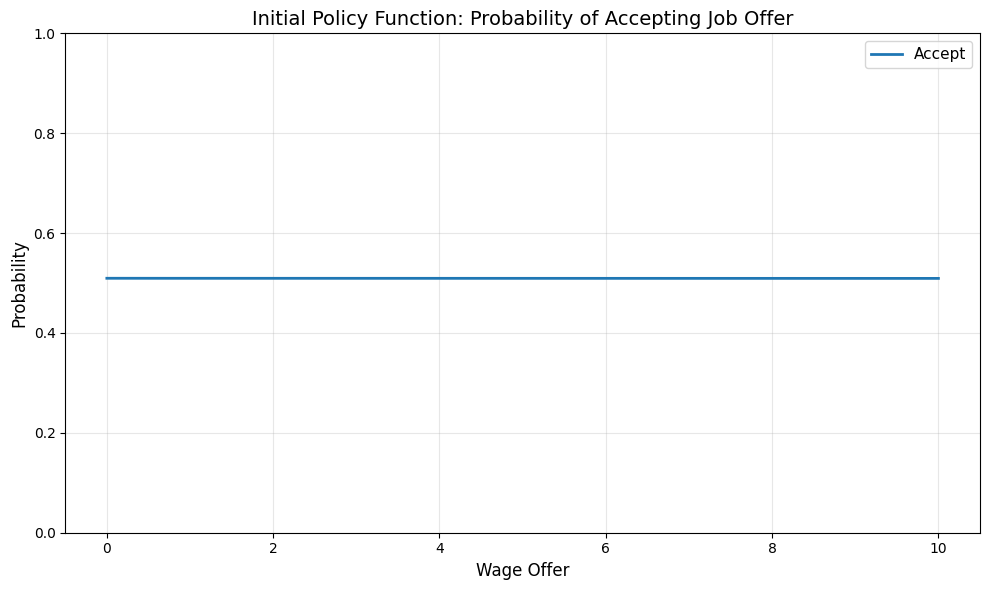

At low wage (w=0.00): P(accept)=0.510
At medium wage (w=5.05): P(accept)=0.509
At high wage (w=10.00): P(accept)=0.509


In [25]:
# Create a grid of wage values
w_grid = jnp.linspace(0.0, 10.0, 100)

# Vectorize the forward function to evaluate over the grid
policy_vmap = jax.vmap(lambda w: forward_2d(params_pg, w))
probs_grid = policy_vmap(w_grid)

# Extract probabilities for accept (1)
prob_accept = probs_grid[:, 1]

# Plot the probabilities
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w_grid, prob_accept, label='Accept', linewidth=2)

ax.set_xlabel('Wage Offer', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title('Initial Policy Function: Probability of Accepting Job Offer', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"At low wage (w={w_grid[0]:.2f}): P(accept)={prob_accept[0]:.3f}")
print(f"At medium wage (w={w_grid[50]:.2f}): P(accept)={prob_accept[50]:.3f}")
print(f"At high wage (w={w_grid[-1]:.2f}): P(accept)={prob_accept[-1]:.3f}")

## Policy gradient algorithm

The policy gradient algorithm looks like what John described this morning except, rather than have a deterministic policy, we have a potentially stochastic policy.

In [21]:
@partial(jax.jit, static_argnames=('episode_length',))
def simulate_episode(key, params, model, episode_length):
    """
    Simulate one episode following the policy defined by params.
    Uses jax.lax.scan for efficient compilation.
    
    Returns:
        rewards: Array of rewards received (length episode_length)
        log_probs: Array of log probabilities of actions (length episode_length)
        decision_mask: Binary mask indicating when decisions were made
    """
    β, μ_w, σ_w, c, α = model.β, model.μ_w, model.σ_w, model.c, model.α
    
    def step_fn(carry, t):
        key, employed, current_wage = carry
        key, wage_key, action_key, separation_key = jax.random.split(key, 4)
        
        # Generate wage offer (always, even if employed)
        log_wage_offer = μ_w + jax.random.normal(wage_key)*σ_w
        wage_offer = jnp.exp(log_wage_offer)

        # Determine if we make a decision this step
        making_decision = ~employed
        
        # Get policy probabilities (computed even if not used)
        probs = forward_2d(params, wage_offer)
        
        # Sample action (0=reject, 1=accept) -- `jax.random.categorical` takes
        # logits, not probabilities
        action = jax.random.categorical(action_key, jnp.log(probs + 1e-10))        
        log_prob = jnp.log(probs[action] + 1e-10)

        def unemployed_branch():
            # When unemployed, always receive unemployment compensation this period
            reward = u(c)  # Always get c this period when unemployed
            
            # Employment status changes based on decision
            new_employed = action == 1
            new_wage = wage_offer
            
            return reward, new_employed, new_wage

        def employed_branch():
            # Always receive current wage this period when employed
            reward = u(current_wage)
            
            # Check if lose job (affects next period)
            lose_job = jax.random.uniform(separation_key) < α
            new_employed = ~lose_job
            new_wage = current_wage
            
            return reward, new_employed, new_wage
        
        reward, new_employed, new_wage = jax.lax.cond(
            employed,
            employed_branch,
            unemployed_branch
        )

        # Only use log_prob if we made a decision
        log_prob_masked = jnp.where(making_decision, log_prob, 0.0)

        new_carry = (key, new_employed, new_wage)
        output = (reward, log_prob_masked, making_decision)

        return new_carry, output
    
    # Initial state: unemployed, no wage
    init_carry = (key, False, 0.0)
    
    # Run the scan
    final_carry, outputs = jax.lax.scan(step_fn, init_carry, jnp.arange(episode_length))
    
    rewards, log_probs, decision_mask = outputs
    
    return rewards, log_probs, decision_mask


@jax.jit
def compute_returns(rewards, β):
    """Compute discounted returns for each timestep using scan."""
    def scan_fn(G, reward):
        new_G = reward + β * G
        return new_G, new_G
    
    # Scan backwards through rewards
    _, returns = jax.lax.scan(scan_fn, 0.0, rewards, reverse=True)
    return returns


@partial(jax.jit, static_argnames=('episode_length', 'num_episodes'))
def policy_gradient_loss(params, model, key, episode_length, num_episodes):
    """
    Compute the REINFORCE policy gradient loss.
    Uses vmap to vectorize over episodes for speed.
    """
    # Generate keys for all episodes
    keys = jax.random.split(key, num_episodes)
    
    # Vectorize simulate_episode over episodes
    simulate_batch = jax.vmap(
        lambda k: simulate_episode(k, params, model, episode_length)
    )
    
    # Simulate all episodes in parallel
    rewards_batch, log_probs_batch, decision_mask_batch = simulate_batch(keys)
    
    # Compute returns for all episodes
    returns_batch = jax.vmap(lambda r: compute_returns(r, model.β))(rewards_batch)    
    
    # Compute loss: only include log_probs where decisions were made
    # Multiply by decision_mask to zero out non-decision timesteps
    losses = -jnp.sum(returns_batch * log_probs_batch * decision_mask_batch, axis=1)

    return jnp.mean(losses)

def create_lr_schedule(config):
    """Create learning rate schedule."""
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=config.init_lr,
        transition_steps=config.warmup_steps
    )
    
    decay_fn = optax.exponential_decay(
        init_value=config.init_lr,
        transition_steps=config.decay_steps,
        decay_rate=0.99,
        end_value=config.min_lr
    )
    
    return optax.join_schedules(
        schedules=[warmup_fn, decay_fn],
        boundaries=[config.warmup_steps]
    )

In [26]:
# Create model and optimizer
config_pg = PGConfig()
model = Model()

lr_schedule = create_lr_schedule(config_pg)
optimizer = optax.adam(learning_rate=lr_schedule)

# Re-initialize parameters for training
key_pg = jax.random.PRNGKey(config_pg.seed)
params_pg = initialize_network(key_pg, config_pg.layer_sizes, layer_initial_s={1: 0.0001})
opt_state = optimizer.init(params_pg)

# Training loop
loss_history = []
best_loss = jnp.inf
best_params = params_pg

print("Training policy")
for epoch in range(config_pg.epochs):
    key_pg, subkey = jax.random.split(key_pg)
    
    # Compute loss and gradients (JIT compiled!)
    loss, grads = jax.value_and_grad(policy_gradient_loss)(
        params_pg, model, subkey, config_pg.episode_length, config_pg.num_episodes
    )

    loss_history.append(float(loss))

    # Track best parameters
    if loss < best_loss:
        best_loss = loss
        best_params = params_pg

    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params_pg = optax.apply_updates(params_pg, updates)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{config_pg.epochs}: Loss = {loss:.4f}")

# Use best parameters
params = params_pg
print(f"\nTraining complete! Best loss: {best_loss:.4f}")

Training policy
Epoch 0/1500: Loss = -0.2549
Epoch 100/1500: Loss = 7.0627
Epoch 200/1500: Loss = 2.9572
Epoch 300/1500: Loss = 2.2099
Epoch 400/1500: Loss = 1.5802
Epoch 500/1500: Loss = 1.7125
Epoch 600/1500: Loss = 1.2760
Epoch 700/1500: Loss = 1.1203
Epoch 800/1500: Loss = 1.0530
Epoch 900/1500: Loss = 0.8227
Epoch 1000/1500: Loss = 0.8725
Epoch 1100/1500: Loss = 0.8959
Epoch 1200/1500: Loss = 0.6250
Epoch 1300/1500: Loss = 0.9723
Epoch 1400/1500: Loss = 0.5511

Training complete! Best loss: -2.1925


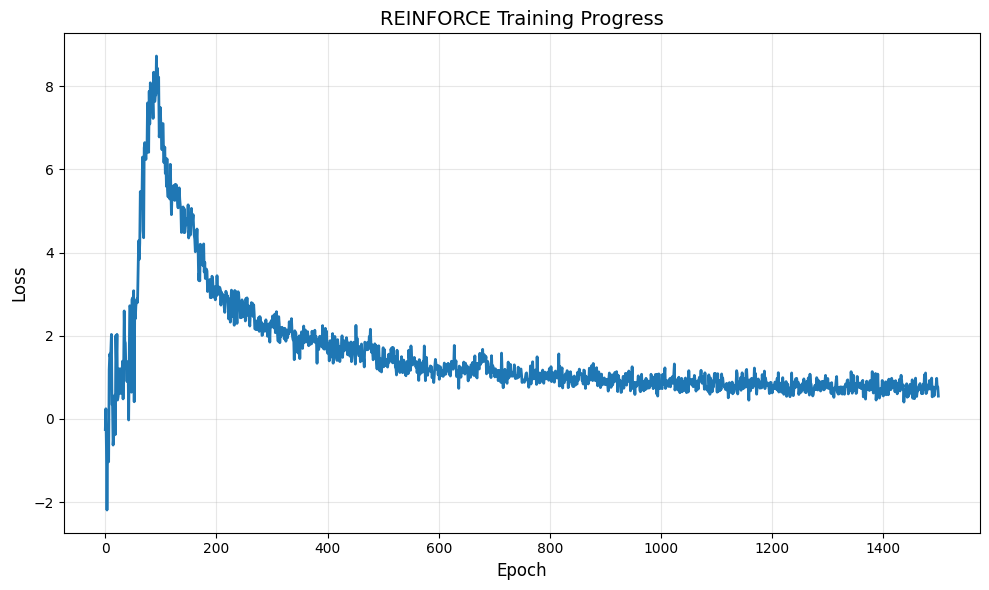

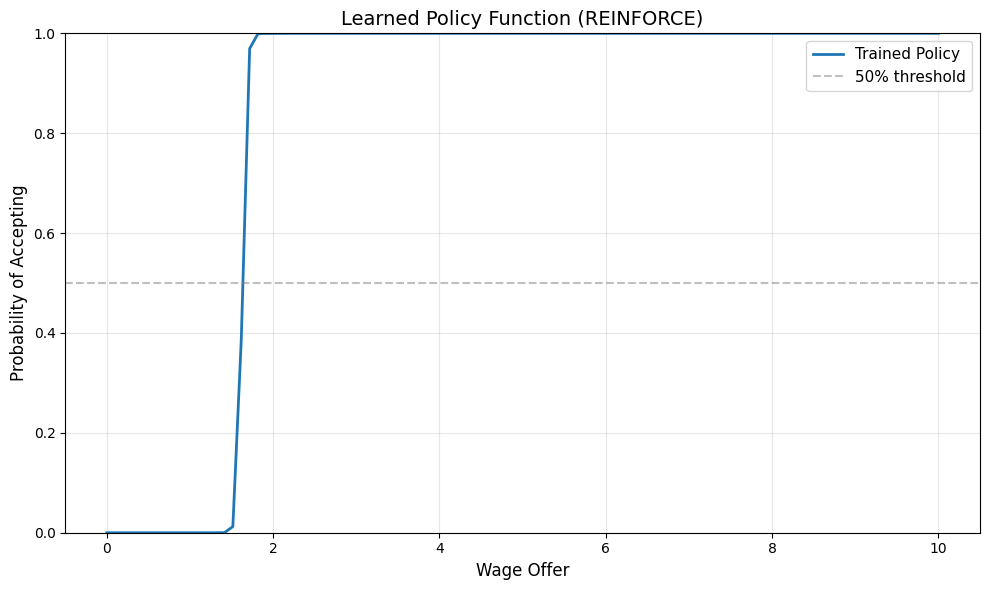


Policy characteristics:
At low wage (w=0.00): P(accept)=0.000
At medium wage (w=5.05): P(accept)=1.000
At high wage (w=10.00): P(accept)=1.000


In [27]:
# Plot learning progress
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_history, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('REINFORCE Training Progress', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot learned policy
w_grid_trained = jnp.linspace(0.0, 10.0, 100)
policy_vmap_trained = jax.vmap(lambda w: forward_2d(params, w))
probs_grid_trained = policy_vmap_trained(w_grid_trained)
prob_accept_trained = probs_grid_trained[:, 1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w_grid_trained, prob_accept_trained, linewidth=2, label='Trained Policy')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax.set_xlabel('Wage Offer', fontsize=12)
ax.set_ylabel('Probability of Accepting', fontsize=12)
ax.set_title('Learned Policy Function (REINFORCE)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"\nPolicy characteristics:")
print(f"At low wage (w={w_grid_trained[0]:.2f}): P(accept)={prob_accept_trained[0]:.3f}")
print(f"At medium wage (w={w_grid_trained[50]:.2f}): P(accept)={prob_accept_trained[50]:.3f}")
print(f"At high wage (w={w_grid_trained[-1]:.2f}): P(accept)={prob_accept_trained[-1]:.3f}")

## Actor-critic algorithm

The policy methods described above depend quite heavily on sampling an entire sequence and then making a single update to the parameters which means that they can end up with a relatively high variance (which isn't particularly desirable). This also means that the policy gradient methods upweight (or downweight) _all_ of the actions taken on the generated history so your gradients aren't as useful as you might like since it's hard to tease out "what were the good actions" and "what were the bad actions"...

To try to resolve these issues (and particularly the second one), methods like "actor-critic" have been developed.

![Actor-Critic](https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/ac.jpg)

^Image credit to HuggingFace RL course

In an actor-critic model, you train two networks -- One network for the policy function and one network for the value function. The network for the policy function (actor) is trained similarly to how we discussed in policy gradient methods but with one added feature, "the critic"

The critic is simply a network that can evaluate whether the action taken by the agent was a good one or a bad one.

**Advantage Actor Critic**

In [16]:
class ACConfig:
    """
    Configuration for training the actor-critic network.
    """
    seed = 20251204
    epochs = 500
    episode_length = 50
    num_episodes = 250
    actor_layer_sizes = (1, 32, 8, 32, 2)
    critic_layer_sizes = (1, 32, 8, 32, 1)
    init_lr = 0.05
    min_lr = 0.0005
    warmup_steps = 500
    decay_steps = 250

In [17]:
@partial(jax.jit, static_argnames=('episode_length',))
def simulate_episode_ac(key, actor_params, critic_params, model, episode_length):
    """
    Simulate one episode for actor-critic.
    Computes TD errors on the fly with proper next-state value estimation.
    
    Returns:
        rewards: Array of rewards
        log_probs: Array of log probabilities
        values: Array of state values
        next_values: Array of next state values (for TD error)
        decision_mask: Binary mask for decisions
    """
    β, μ_w, σ_w, c, α = model.β, model.μ_w, model.σ_w, model.c, model.α
    
    def step_fn(carry, t):
        key, employed, current_wage = carry
        key, k1, k2, k3, k4 = jax.random.split(key, 5)
        
        # Generate current wage offer
        log_wage_offer = μ_w + jax.random.normal(k1) * σ_w
        wage_offer = jnp.exp(log_wage_offer)
        
        # Pre-generate NEXT wage offer
        next_log_wage = μ_w + jax.random.normal(k4) * σ_w
        next_wage_offer = jnp.exp(next_log_wage)
        
        # Determine if making decision
        making_decision = ~employed
        
        # Get policy probabilities and value for current state
        probs = forward_2d(actor_params, wage_offer)
        value = forward_1d(critic_params, wage_offer)[0]
        
        # Sample action
        action = jax.random.categorical(k2, jnp.log(probs + 1e-10))
        log_prob = jnp.log(probs[action] + 1e-10)
        
        # Compute reward and next state
        def unemployed_branch():
            # When unemployed, always receive unemployment compensation this period
            reward = u(c)
            
            # Employment status changes based on decision
            new_employed = action == 1
            new_wage = wage_offer
            
            # Next value: if accept, value of that wage; if reject, value of next draw
            next_val_wage = jnp.where(action == 1, wage_offer, next_wage_offer)
            return reward, new_employed, new_wage, next_val_wage
        
        def employed_branch():
            # Always receive current wage this period when employed
            reward = u(current_wage)
            
            # Check if lose job (affects next period)
            lose_job = jax.random.uniform(k3) < α
            new_employed = ~lose_job
            new_wage = current_wage
            
            # Next value: if keep job, value of current wage; if lose, value of next draw
            next_val_wage = jnp.where(lose_job, next_wage_offer, current_wage)
            return reward, new_employed, new_wage, next_val_wage
        
        reward, new_employed, new_wage, next_val_wage = jax.lax.cond(
            employed,
            employed_branch,
            unemployed_branch
        )
        
        # Compute next state value
        next_value = forward_1d(critic_params, next_val_wage)[0]
        
        # Mask outputs (only for decisions made)
        log_prob_masked = jnp.where(making_decision, log_prob, 0.0)
        value_masked = jnp.where(making_decision, value, 0.0)
        next_value_masked = jnp.where(making_decision, next_value, 0.0)
        
        new_carry = (key, new_employed, new_wage)
        output = (reward, log_prob_masked, value_masked, next_value_masked, making_decision)
        
        return new_carry, output
    
    init_carry = (key, False, 0.0)
    final_carry, outputs = jax.lax.scan(step_fn, init_carry, jnp.arange(episode_length))
    
    rewards, log_probs, values, next_values, decision_mask = outputs
    
    return rewards, log_probs, values, next_values, decision_mask

@partial(jax.jit, static_argnames=('episode_length', 'num_episodes'))
def actor_critic_loss(actor_params, critic_params, model, key, episode_length, num_episodes):
    """
    Compute actor-critic loss.
    Actor loss: -log π(a|s) * advantage
    Critic loss: (V(s) - target)^2
    """
    keys = jax.random.split(key, num_episodes)
    
    # Vectorize over episodes
    simulate_batch = jax.vmap(
        lambda k: simulate_episode_ac(k, actor_params, critic_params, model, episode_length)
    )
    
    # Simulate all episodes
    rewards_batch, log_probs_batch, values_batch, next_values_batch, decision_mask_batch = simulate_batch(keys)
    
    # Compute TD errors (advantages)
    # advantage = reward + γ * V(s') - V(s)
    td_targets = rewards_batch + model.β * next_values_batch
    advantages = td_targets - values_batch

    # Actor loss: policy gradient with advantage
    actor_losses = -jnp.sum(log_probs_batch * advantages * decision_mask_batch, axis=1)
    
    # Critic loss: MSE between value and TD target
    critic_losses = jnp.sum(decision_mask_batch * (values_batch - td_targets)**2, axis=1)
    
    # Average over episodes
    actor_loss = jnp.mean(actor_losses)
    critic_loss = jnp.mean(critic_losses)
    
    return actor_loss, critic_loss

Training Actor-Critic...
Epoch 0/500: Actor Loss = 2.4575, Critic Loss = 5.1215
Epoch 100/500: Actor Loss = 0.0405, Critic Loss = 0.0008
Epoch 200/500: Actor Loss = 0.0055, Critic Loss = 0.0007
Epoch 300/500: Actor Loss = -0.0069, Critic Loss = 0.0009
Epoch 400/500: Actor Loss = -0.0007, Critic Loss = 0.0002


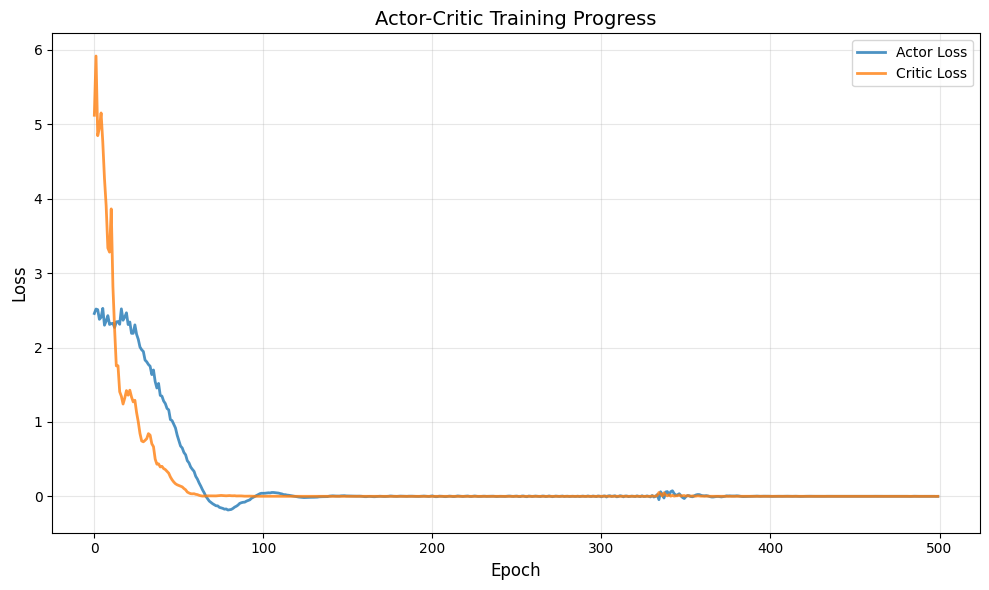

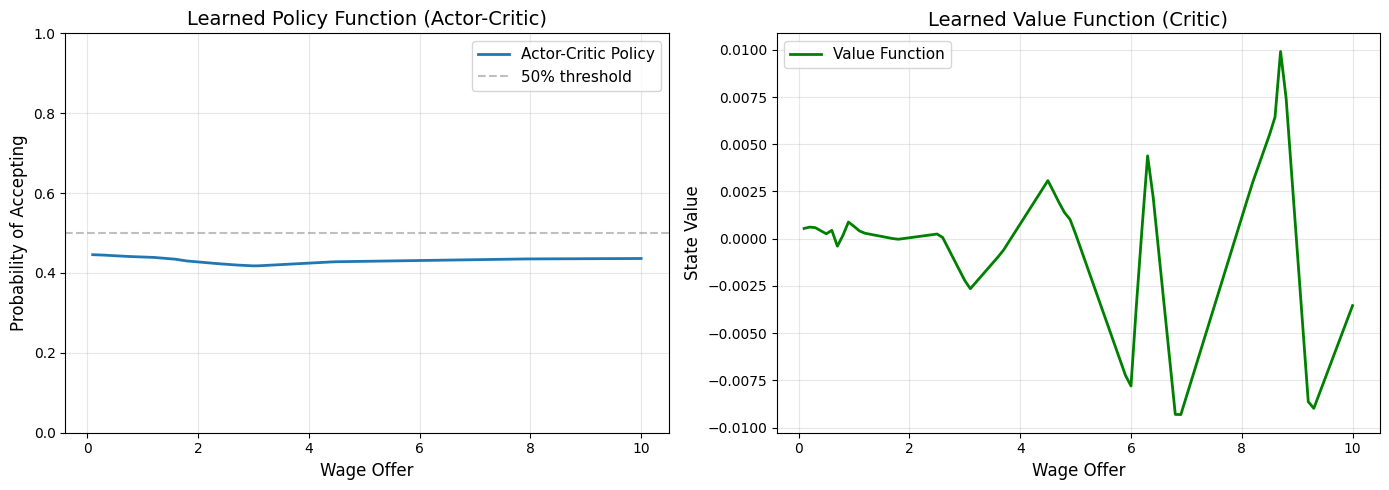


Policy characteristics:
At low wage (w=0.10): P(accept)=0.446, V=0.001
At medium wage (w=5.10): P(accept)=0.429, V=-0.001
At high wage (w=10.00): P(accept)=0.436, V=-0.004


In [18]:
# Create model and optimizer
config_ac = ACConfig()
model_ac = Model()

lr_schedule_ac = create_lr_schedule(config_ac)
actor_optimizer = optax.adam(learning_rate=lr_schedule_ac)
critic_optimizer = optax.adam(learning_rate=lr_schedule_ac)

# Initialize actor and critic networks
key_ac = jax.random.PRNGKey(config_ac.seed)
key_ac, actor_key, critic_key = jax.random.split(key_ac, 3)

actor_params = initialize_network(actor_key, config_ac.actor_layer_sizes, layer_initial_s={3: 0.0001})
critic_params = initialize_network(critic_key, config_ac.critic_layer_sizes)

actor_opt_state = actor_optimizer.init(actor_params)
critic_opt_state = critic_optimizer.init(critic_params)

# Training loop
actor_loss_history = []
critic_loss_history = []
best_actor_loss = jnp.inf
best_actor_params = actor_params
best_critic_params = critic_params

print("Training Actor-Critic...")

for epoch in range(config_ac.epochs):
    key_ac, subkey = jax.random.split(key_ac)
    
    # Compute gradients for both actor and critic
    def actor_loss_fn(a_params):
        actor_l, critic_l = actor_critic_loss(
            a_params, critic_params, model_ac, subkey, 
            config_ac.episode_length, config_ac.num_episodes
        )
        return actor_l
    
    def critic_loss_fn(c_params):
        actor_l, critic_l = actor_critic_loss(
            actor_params, c_params, model_ac, subkey, 
            config_ac.episode_length, config_ac.num_episodes
        )
        return critic_l
    
    # Compute losses and gradients
    actor_loss, actor_grads = jax.value_and_grad(actor_loss_fn)(actor_params)
    critic_loss, critic_grads = jax.value_and_grad(critic_loss_fn)(critic_params)
    
    actor_loss_history.append(float(actor_loss))
    critic_loss_history.append(float(critic_loss))
    
    # Update parameters
    actor_updates, actor_opt_state = actor_optimizer.update(actor_grads, actor_opt_state)
    actor_params = optax.apply_updates(actor_params, actor_updates)
    
    critic_updates, critic_opt_state = critic_optimizer.update(critic_grads, critic_opt_state)
    critic_params = optax.apply_updates(critic_params, critic_updates)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{config_ac.epochs}: "
              f"Actor Loss = {actor_loss:.4f}, Critic Loss = {critic_loss:.4f}")

# Plot learning progress
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(actor_loss_history, linewidth=2, label='Actor Loss', alpha=0.8)
ax.plot(critic_loss_history, linewidth=2, label='Critic Loss', alpha=0.8)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Actor-Critic Training Progress', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot learned policy and value function
w_grid_ac = jnp.linspace(0.1, 10.0, 100)
policy_vmap_ac = jax.vmap(lambda w: forward_2d(actor_params, w))
value_vmap_ac = jax.vmap(lambda w: forward_1d(critic_params, w)[0])

probs_grid_ac = policy_vmap_ac(w_grid_ac)
prob_accept_ac = probs_grid_ac[:, 1]
values_grid_ac = value_vmap_ac(w_grid_ac)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot policy
ax1.plot(w_grid_ac, prob_accept_ac, linewidth=2, label='Actor-Critic Policy')
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax1.set_xlabel('Wage Offer', fontsize=12)
ax1.set_ylabel('Probability of Accepting', fontsize=12)
ax1.set_title('Learned Policy Function (Actor-Critic)', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot value function
ax2.plot(w_grid_ac, values_grid_ac, linewidth=2, color='green', label='Value Function')
ax2.set_xlabel('Wage Offer', fontsize=12)
ax2.set_ylabel('State Value', fontsize=12)
ax2.set_title('Learned Value Function (Critic)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPolicy characteristics:")
print(f"At low wage (w={w_grid_ac[0]:.2f}): P(accept)={prob_accept_ac[0]:.3f}, V={values_grid_ac[0]:.3f}")
print(f"At medium wage (w={w_grid_ac[50]:.2f}): P(accept)={prob_accept_ac[50]:.3f}, V={values_grid_ac[50]:.3f}")
print(f"At high wage (w={w_grid_ac[-1]:.2f}): P(accept)={prob_accept_ac[-1]:.3f}, V={values_grid_ac[-1]:.3f}")